This approach retrains the models with the full train data once we do the k-fold

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

In [2]:
kfold_seed = 0
models_seed = 0
np_seed = 0

# Compute Gini metric functions

In [3]:
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini
    
    
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

# Target encoding functions

In [4]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

# Read data

In [5]:
# Read data
train_df = pd.read_csv('data/train.csv', na_values="-1") 
test_df = pd.read_csv('data/test.csv', na_values="-1")

# Features to use

In [6]:
# Nulls count, not tested
train_df['nulls_count'] = train_df.isnull().sum(axis=1)
test_df['nulls_count'] = test_df.isnull().sum(axis=1)

# from olivier
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
    #"nulls_count" #            : not analized
]
# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
    ('ps_ind_02_cat', 'ps_ind_03')
    #ps_ind_05_cat|ps_ind_16_bin
]



# Extra feature engineering 

In [7]:
#sum_ps_ind_03_ps_calc_02	0.2891251923	VALIDATOIN
#diff_ps_ind_03_ps_ind_15	0.289420424	VALIDATOIN SCORE IMPROVED!!
train_df['sum_ps_ind_03_ps_calc_02'] = (train_df['ps_ind_03'] + train_df['ps_calc_02']).astype(np.float32)
test_df['sum_ps_ind_03_ps_calc_02'] = (test_df['ps_ind_03'] + test_df['ps_calc_02']).astype(np.float32)
train_features.append('sum_ps_ind_03_ps_calc_02')
train_df['diff_ps_ind_03_ps_ind_15'] = (train_df['ps_ind_03'] + train_df['ps_ind_15']).astype(np.float32)
test_df['diff_ps_ind_03_ps_ind_15'] = (test_df['ps_ind_03'] + test_df['ps_ind_15']).astype(np.float32)
train_features.append('diff_ps_ind_03_ps_ind_15')

# Preprocess data

In [8]:
# Process data
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]

# Setup classifiers

In [9]:
# XGBoost
xgb1_params = {}
xgb1_params['objective'] = "binary:logistic"
xgb1_params['n_estimators'] = 400 # MAX_ROUNDS
xgb1_params['learning_rate'] = 0.07
xgb1_params['max_depth'] = 4
xgb1_params['subsample'] = 0.80
xgb1_params['colsample_bytree'] = 0.80
xgb1_params['min_child_weight'] = 6
xgb1_params['gamma'] = 10
xgb1_params['reg_alpha'] = 8
xgb1_params['reg_lambda'] = 1.5
xgb1_params['scale_pos_weight'] = 1.6
#xgb1_params['max_delta_step'] = 0
xgb1_params['seed'] = models_seed
xgb1 = XGBClassifier(**xgb1_params)

xgb2_params = {'eta': 0.025, 'max_depth': 4, 
          'subsample': 0.9, 'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
            'min_child_weight':100,
            'alpha':4,
            'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}

# LightGBM
lgb1_params = {}
lgb1_params['learning_rate'] = 0.02
lgb1_params['n_estimators'] = 650
lgb1_params['max_bin'] = 10
lgb1_params['subsample'] = 0.8
lgb1_params['subsample_freq'] = 10
lgb1_params['colsample_bytree'] = 0.8   
lgb1_params['min_child_samples'] = 500
lgb1_params['seed'] = models_seed
lgb1 = LGBMClassifier(**lgb1_params)

lgb2_params = {}
lgb2_params['n_estimators'] = 1090
lgb2_params['learning_rate'] = 0.02
lgb2_params['colsample_bytree'] = 0.3   
lgb2_params['subsample'] = 0.7
lgb2_params['subsample_freq'] = 2
lgb2_params['num_leaves'] = 16
lgb2_params['seed'] = 99
lgb2 = LGBMClassifier(**lgb2_params)


# Put all models in list
models = [xgb1, lgb1, lgb2]
models_params = [xgb1_params, lgb1_params, lgb2_params]
models_names = ['xgb1', 'lgb1', 'lgb2']
model_weights = [0.4, 0.3, 0.3]

In [10]:
# Create data set train_meta  and test_meta
train_meta = train_df[['id', 'target']].copy()
test_meta = pd.DataFrame()
test_meta['id'] = id_test
for m in models_names:
    train_meta[m] = 0
    test_meta[m] = 0

# K fold CV

In [11]:
y_valid_pred = 0*y


# Set up folds
K = 5
kf = KFold(n_splits = K, random_state = kfold_seed, shuffle = True)
# Also try with stratified
np.random.seed(np_seed)

# Run CV

for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
    
    # Enocode data
    for f in f_cats:
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
        
    l_gini_train = []
    l_gini_val = []
    for model,model_params,model_name, model_weight in zip(models, models_params, models_names, model_weights):
        #Fit the base model to the training fold 
        
        print('Train model ' + model_name)
        #print('Parameters: ')
        #print(model_params)
        fit_model = model.fit(X_train, y_train)
        # if xgboost model, save it
        if 'xgb' in model_name:
            fit_model.booster().dump_model(model_name + '_fold' + str(i) + '.dump',  with_stats=True)
        
        # Train error
        pred = fit_model.predict_proba(X_train)[:,1]
        l_gini_train.append(eval_gini(y_train, pred))
        print("TrainGini = ", str(l_gini_train[-1]))
        
        # make predictions on the test fold. Store these predictions in train_meta to be used as features for the stacking model
        pred = fit_model.predict_proba(X_valid)[:,1]
        l_gini_val.append(eval_gini(y_valid, pred))
        print("Val Gini = ", str(l_gini_val[-1]))
        train_meta.loc[test_index, model_name] = pred
              
        y_valid_pred.iloc[test_index] += pred * model_weight

        print('---------NEXT MODEL---------')
    print('Mean train error: ' + str(np.mean(l_gini_train)))
    print('Mean val error: ' + str(np.mean(l_gini_val)))
    
    del X_test, X_train, X_valid, y_train
        
    print('---------------------------------------END FOLD------------------------------------------')
    

print( "\nGini for full training set:" )
print(eval_gini(y, y_valid_pred))


Fold  0
Train model xgb1
TrainGini =  0.340995849324
Val Gini =  0.282453654989
---------NEXT MODEL---------
Train model lgb1
TrainGini =  0.398282048294
Val Gini =  0.285986558143
---------NEXT MODEL---------
Train model lgb2
TrainGini =  0.377447890178
Val Gini =  0.281336782324
---------NEXT MODEL---------
Mean train error: 0.372241929266
Mean val error: 0.283258998485
---------------------------------------END FOLD------------------------------------------

Fold  1
Train model xgb1
TrainGini =  0.343265021256
Val Gini =  0.285166507865
---------NEXT MODEL---------
Train model lgb1
TrainGini =  0.4031174467
Val Gini =  0.282233001495
---------NEXT MODEL---------
Train model lgb2
TrainGini =  0.380758983816
Val Gini =  0.287919904935
---------NEXT MODEL---------
Mean train error: 0.375713817258
Mean val error: 0.285106471432
---------------------------------------END FOLD------------------------------------------

Fold  2
Train model xgb1
TrainGini =  0.343838942595
Val Gini =  0.28

In [12]:
# Enocode data
for f in f_cats:
    X[f + "_avg"], valid, test_df[f + "_avg"] = target_encode(
        trn_series=X[f],
        val_series=X[f].iloc[0:5].copy(),
        tst_series=test_df[f],
        target=y,
        min_samples_leaf=200,
        smoothing=10,
        noise_level=0
        )
del valid

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# Fit each base model to the full training dataset

for model,model_name in zip(models, models_names):
    print('Train model ' + model_name + ' on full data')
    fit_model = model.fit(X, y, verbose=True,)
    # make predictions on the test dataset.
    pred = fit_model.predict_proba(test_df)[:,1]
    # Store these predictions inside test_meta
    test_meta[model_name] = pred

Train model xgb1 on full data
Train model lgb1 on full data
Train model lgb2 on full data


In [30]:
# K-fold CV for hyperparemeter tuning of the stacked model
stacking_model = LogisticRegression(C=0.001)
val_gini_stack = []
for i, (train_index, test_index) in enumerate(kf.split(train_df)):
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = train_meta.loc[train_index,models_names].copy(), train_meta.loc[test_index,models_names].copy()
    stacking_model.fit(X_train, y_train)
    pred = stacking_model.predict_proba(X_valid)[:,1]
    val_gini_stack.append(eval_gini(y_valid, pred))
    print("Val Gini = ", str(val_gini_stack[-1]))
print(np.mean(val_gini_stack))

Val Gini =  0.28494696258
Val Gini =  0.287284671488
Val Gini =  0.287554701478
Val Gini =  0.303945679265
Val Gini =  0.280061312483
0.288758665459


In [31]:
# Fit a new model, S (i.e the stacking model) to train_meta, using predictions of other models as features. 
# Optionally, include other features from the original training dataset or engineered features
stacking_model = LogisticRegression(C=0.01)
stacking_model.fit(train_meta[models_names], y)
# Use the stacked model S to make final predictions on test_meta
res = stacking_model.predict_proba(test_meta[models_names])[:,1]

sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = res
sub.to_csv('stacked_1.csv', index=False)
print(stacking_model.coef_)
print(stacking_model.intercept_ )

[[ 2.38254782  1.60340036  1.59509317]]
[-3.51913946]


# Show correlation between the different model predictions

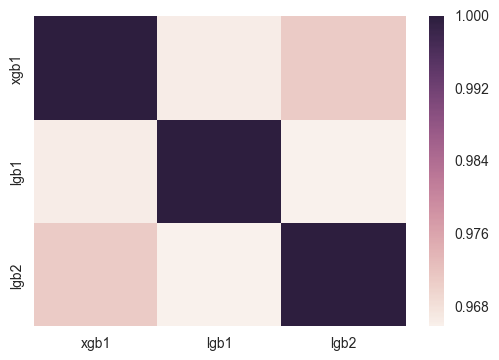

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = train_meta[models_names].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)